# Setup

In [1]:
# library to check function types of imported modules
from typeguard import install_import_hook

# custom functions for plotting, etc.
with install_import_hook('custom_ml_plots'):
    import custom_ml_plots as cmp
with install_import_hook('custom_dataset_tools'):
    import custom_dataset_tools as cdt
with install_import_hook('basic_ml_operations'):
    import basic_ml_operations as bmo
with install_import_hook('ml_data_objects'):
    import ml_data_objects as mdo

# data import
import pyreadr

# data storage libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

from typing import Tuple

from matplotlib import pyplot as plt


# Scaling
from sklearn.preprocessing import StandardScaler

# k-fold cross-validation
from sklearn.model_selection import KFold

# global parameters
RANDOM_STATE = 42
TEST_SET_PORTION = 0.15
CV_SET_PORTION = 0.15
TOP_LINE_THRESH = 0.8

## Import Data

In [2]:
# import dataset
eyt1 = pyreadr.read_r('./data/eyt1.RData')

# extract training example labels
y = eyt1['Pheno_Disc_Env1']

y.head()

GID     Env  DTHD  DTMT        GY  Height
0  GID6569128  Bed5IR   1.0   1.0  6.119272     0.0
1  GID6688880  Bed5IR   2.0   2.0  5.855879     0.0
2  GID6688916  Bed5IR   2.0   2.0  6.434748     0.0
3  GID6688933  Bed5IR   2.0   2.0  6.350670     0.0
4  GID6688934  Bed5IR   1.0   2.0  6.523289     0.0

In [3]:
y = y[['GY']].set_index(y['GID'])

# sort by index
y = y.sort_index()

# check missing values
cdt.assert_no_bad_values(y)

# each seed was planted in 4 different environments, but we don't care about environmental differences
# so we take the average of every group of four rows to reduce the dataset to 1/4 its original size
y = cdt.avg_rows(y, 4)

y.head()

GY
GID                 
GID6569128  5.160521
GID6688880  5.988963
GID6688916  5.781745
GID6688933  5.434369
GID6688934  5.551610

In [4]:
# extract feature matrix
X = eyt1['Geno_Env1']

X.head()

GID6569128  GID6688880  GID6688916  GID6688933  GID6688934  \
GID6569128    0.788801   -0.006443    0.025987   -0.138795   -0.157880   
GID6688880   -0.006443    0.980542    0.064585   -0.168773   -0.081006   
GID6688916    0.025987    0.064585    1.170073   -0.021636   -0.031717   
GID6688933   -0.138795   -0.168773   -0.021636    0.879004    0.443678   
GID6688934   -0.157880   -0.081006   -0.031717    0.443678    0.996666   

            GID6688949  GID6689407  GID6689482  GID6689550  GID6738288  ...  \
GID6569128    0.096213   -0.110899    0.013069   -0.040445    0.007931  ...   
GID6688880    0.078890   -0.201346    0.124671    0.253505    0.013636  ...   
GID6688916    0.101532   -0.196780    0.041900   -0.013459    0.126464  ...   
GID6688933   -0.080560    0.402479   -0.218803   -0.102718   -0.002303  ...   
GID6688934   -0.140766    0.395843   -0.310471   -0.138902    0.088169  ...   

            GID6939899  GID6939900  GID6939902  GID6939903  GID6939904  \
GID6569128    0.125612    0.133808    0.137456    0.127674    0.130468   
GID6688880    0.072171    0.061650    0.057898    0.079085    0.061086   
GID6688916    0.428609    0.423184    0.427788    0.408326    0.426844   
GID6688933   -0.079312   -0.087824   -0.089912   -0.067028   -0.084206   
GID6688934   -0.016690   -0.017375   -0.026372   -0.014478   -0.016350   

            GID6939917  GID6939919  GID6939938  GID6939941  GID6939945  
GID6569128    0.004096    0.091188    0.074009    0.032992    0.199459  
GID6688880    0.104630    0.113878    0.108757    0.154718    0.004447  
GID6688916    0.006038    0.209395    0.240468    0.255337    0.163524  
GID6688933   -0.140529   -0.088961   -0.096740   -0.159136   -0.108800  
GID6688934   -0.098509   -0.052304   -0.012778   -0.100318   -0.154557  

[5 rows x 766 columns]

In [5]:
# scale feature matrix
X_scaler = StandardScaler()
X_sc = pd.DataFrame(X_scaler.fit_transform(X), index=X.index, columns=X.columns)

y_scaler = StandardScaler()
y_sc = pd.DataFrame(y_scaler.fit_transform(y), index=y.index, columns=y.columns)

y_sc.head()

GY
GID                 
GID6569128 -1.069311
GID6688880  1.412830
GID6688916  0.791971
GID6688933 -0.248819
GID6688934  0.102451

In [6]:

def plot_shaded_scatter_grids(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, pearson_grid: np.ndarray, plot_title: str, i: int):
    """
    Plot predictions vs actuals and colour by pearson coefficient and add best fit
    Created: 2024/11/30
    """
    # create plot of predictions vs actuals
    fig, axs = cmp.create_scatter_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, f"{plot_title} | Inner Fold {i}")

    # colour by pearson coefficient and add best fit and title
    cmp.color_spectrum(fig, axs, pearson_grid, label="Pearson Coefficient")
    cmp.add_best_fit(axs)
    plt.show(fig)
    plt.close(fig)

In [7]:

def plot_shaded_roc_grids(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, f1_grid: np.ndarray, plot_title: str, i: int):
    """
    Plot predictions vs actuals and colour by pearson coefficient and add best fit
    Created: 2024/12/22
    """
    # create plot of predictions vs actuals
    fig, axs = cmp.create_roc_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, f"{plot_title} | Inner Fold {i}")

    # colour by pearson coefficient and add best fit and title
    cmp.color_spectrum(fig, axs, f1_grid, label="f1 Score")
    cmp.add_best_fit(axs)
    plt.show(fig)
    plt.close(fig)

# Model R

In [8]:
def inner_CV_R(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, plot_title: str = "", **kwargs):
    """    Perform inner cross-validation with grid search to find the best model parameters.
    Parameters:
    -----------
    n_splits : int
        Number of splits for KFold cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Parameter grid for the first axis.
    axis2_params : mdo.AxisParams
        Parameter grid for the second axis.
    train_model_callback : callable
        Callback function to train the model.
    kfold_random_state : int
        Random state for KFold shuffling.
    plot_title : str, optional
        Title for the plot (default is "").
    **kwargs : dict
        Additional keyword arguments for the model training.
    Returns:
    --------
    avg_best_param1 : float
        Average best parameter value for the first axis over all folds.
    avg_best_param2 : float
        Average best parameter value for the second axis over all folds."""

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # arrays to store best parameters for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        """
        # For debugging
        print(f'Fold {i}')
        """
        
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        """
        # For debugging
        print('Training data:')
        print(f'X: {X_train}')
        print(f'y: {y_train}')
        """
        
        # train model grid
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # use trained models to predict test set
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # create grid of actuals to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # evaluate predictions by comparing to actuals, calculating pearson coefficient
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        """
        # For debugging
        print(f'Model grid:')
        # print each model's tree count and depth
        for row in range(model_grid.shape[0]):
            for col in range(model_grid.shape[1]):
                model = model_grid[row, col]
                print(f'Model at row {row}, col {col}:')
                # print based on whether model is svm or xgb
                if hasattr(model, 'n_estimators'):
                    print(f'n_estimators: {model.get_params()["n_estimators"]}, max_depth: {model.get_params()["max_depth"]}')
                else:    
                    # SVM, print gamma and C
                    print(f'gamma: {model.get_params()["gamma"]}, C: {model.get_params()["C"]}')
        print('Actuals:')
        cdt.pretty_print_np_array_of_dfs(y_test_grid, rows_per_df=6)
        print('Predictions:')
        cdt.pretty_print_np_array_of_dfs(y_preds_grid, rows_per_df=6)
        """

        # find index of best pearson coefficient in the 2d array of pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # store best parameters for this fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]

        plot_shaded_scatter_grids(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, plot_title, i)        

    # calculate average best parameters over all folds
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    return avg_best_param1, avg_best_param2

        

In [9]:
def outer_CV_R(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback : callable, kfold_random_state: int, top_line_thresh : float, **kwargs) -> pd.DataFrame:
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # find average best values using inner fold CV
        best_param1, best_param2 = inner_CV_R(n_inner_splits, X_train, y_train, axis1_params, axis2_params, train_model_callback, kfold_random_state, plot_title=f"Outer Fold {i}", **kwargs)

        # train model with all training data of outer fold using average best parameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # use trained model to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)

        # calculate pearson coefficient
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # classify predictions and actuals as top or not top
        y_pred_top = cdt.classify_top(y_pred, top_line_thresh)
        y_test_top = cdt.classify_top(y_test, top_line_thresh)

        # calculate classification metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)

        # combine pearson and classification metrics into one dataframe side by side, then add them to kfold_metrics
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)        
    
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics

## Support Vector Machine

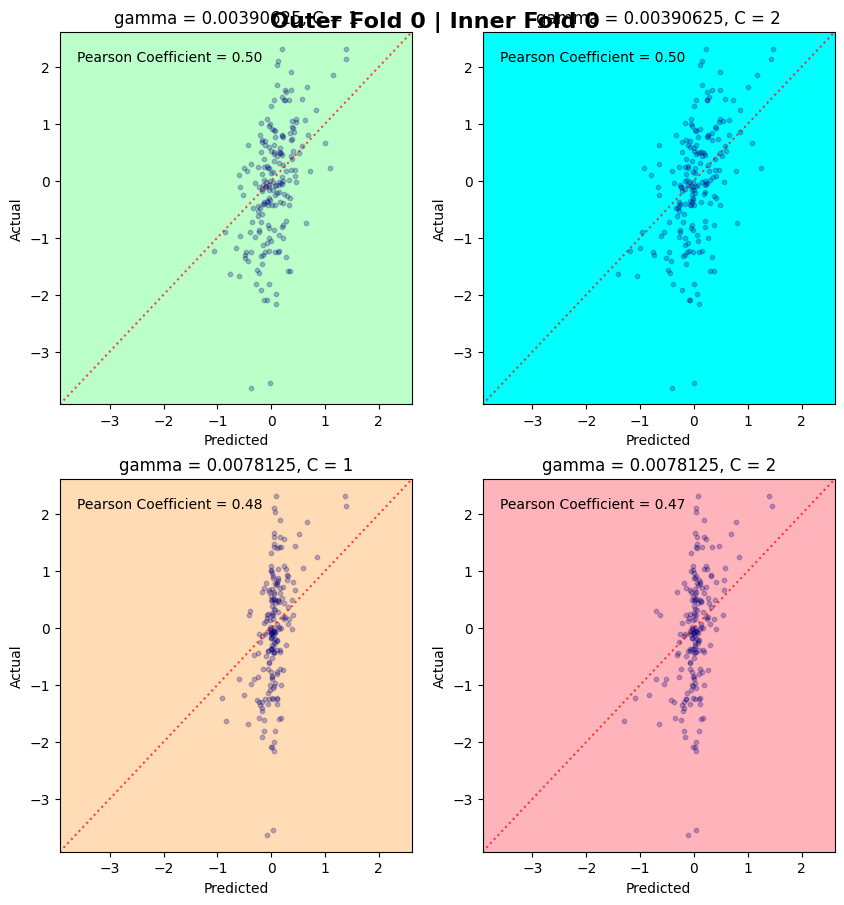

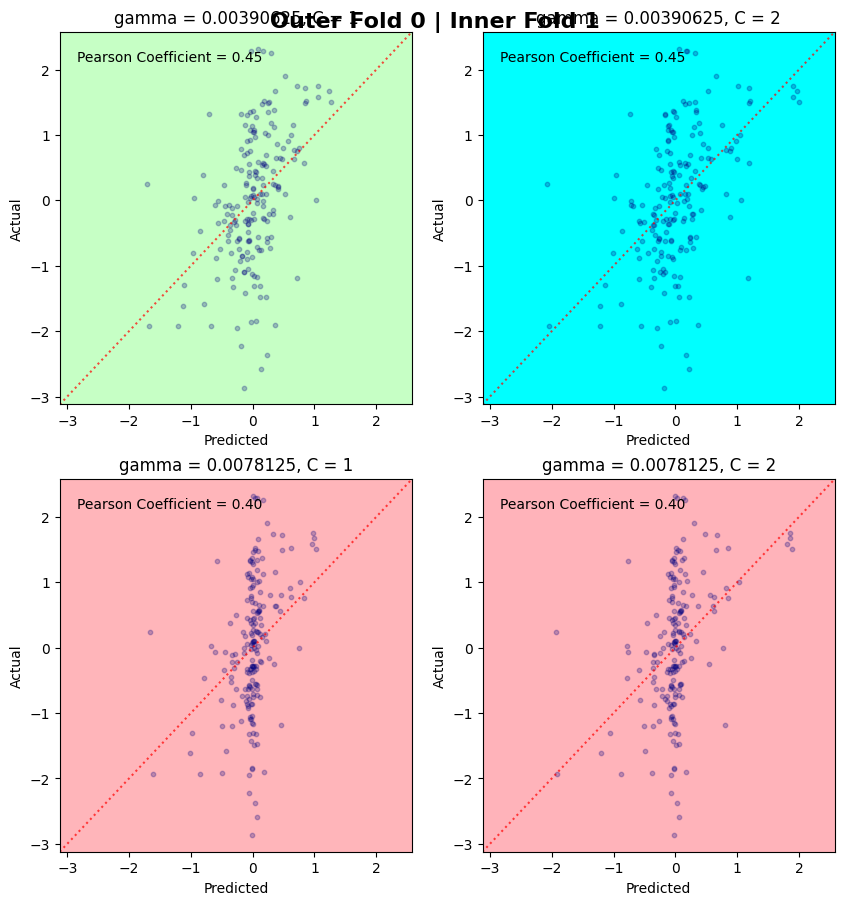

C:\Users\caoca\AppData\Local\Temp\ipykernel_26656\491992401.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)


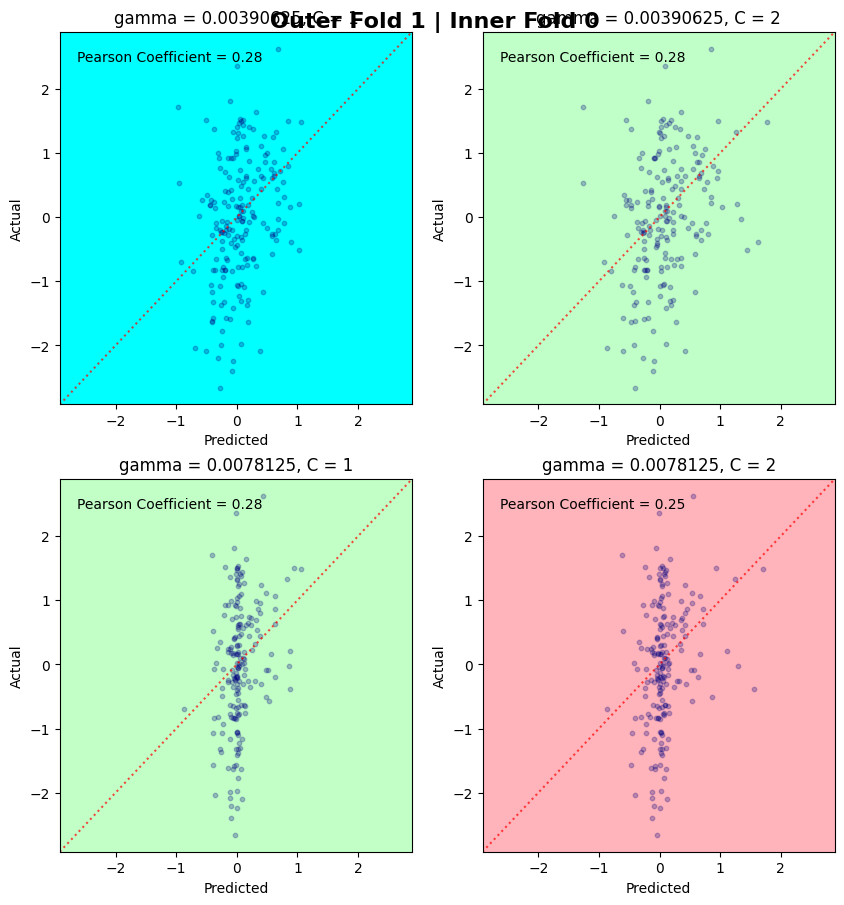

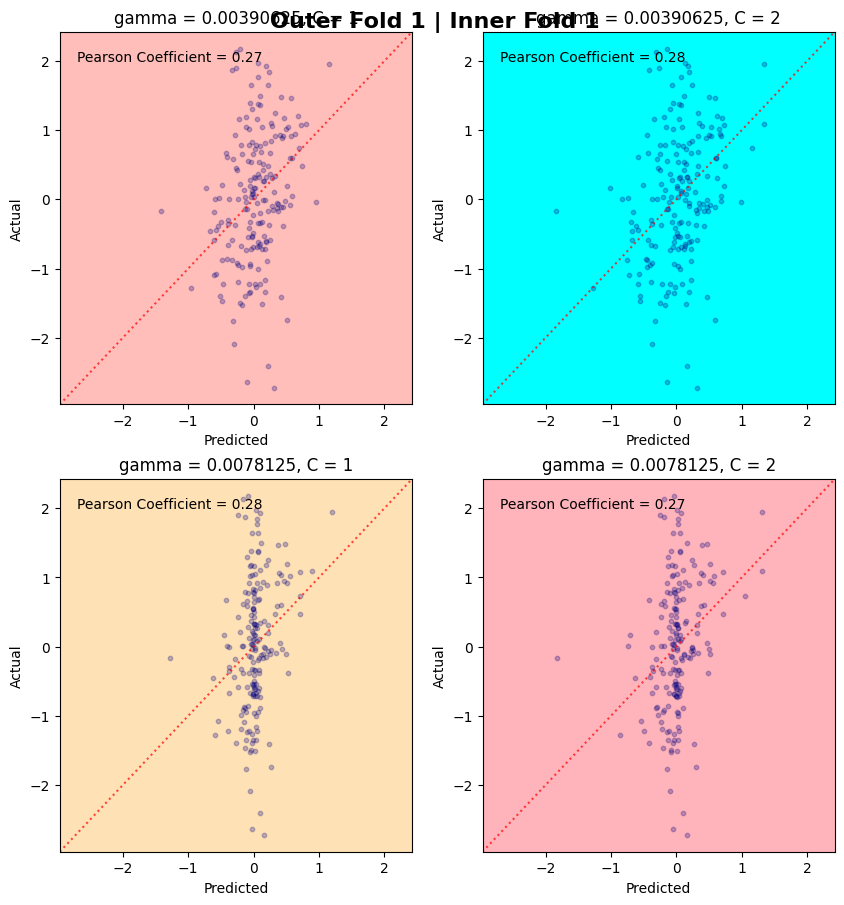

In [10]:
"""# Real values
x_params_SVM_R = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_R = mdo.AxisParams('C', bmo.power_list(2, -2, 6))
metrics_SVM_R = outer_CV_R(10, 5, X_sc, y_sc, x_params_SVM_R, y_params_SVM_R, bmo.train_SVM_regressor, kfold_random_state=RANDOM_STATE, kernel='rbf')
"""
# Dummy values for quick training tests
x_params_SVM_R = mdo.AxisParams('gamma', bmo.power_list(2, -8, -7))
y_params_SVM_R = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
metrics_SVM_R = outer_CV_R(2, 2, X_sc, y_sc, x_params_SVM_R, y_params_SVM_R, bmo.train_SVM_regressor, kfold_random_state=RANDOM_STATE, kernel='rbf', top_line_thresh=TOP_LINE_THRESH)


In [11]:
# display metrics
display(metrics_SVM_R)

Pearson  F1 Score  Sensitivity  Specificity     Kappa
0  0.402901  0.350649     0.350649     0.836601  0.187251
1  0.445206  0.389610     0.389610     0.846405  0.236016

In [12]:
# Print average of each metric
display(metrics_SVM_R.mean())

Pearson        0.424053
F1 Score       0.370130
Sensitivity    0.370130
Specificity    0.841503
Kappa          0.211633
dtype: float64

## XGBoost

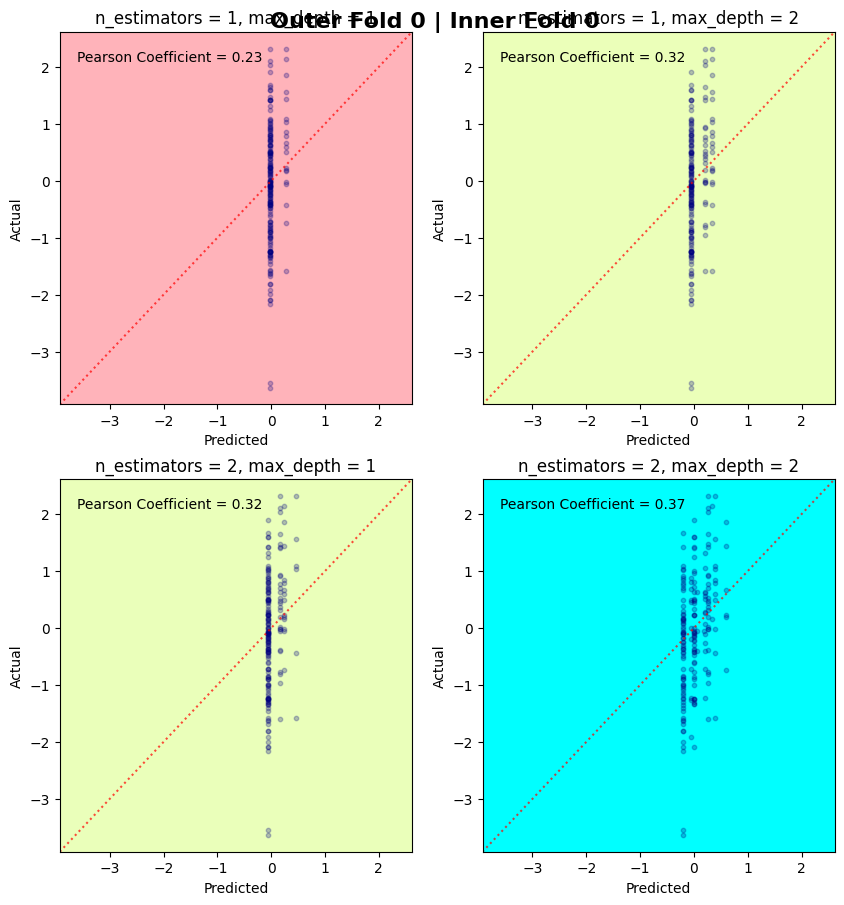

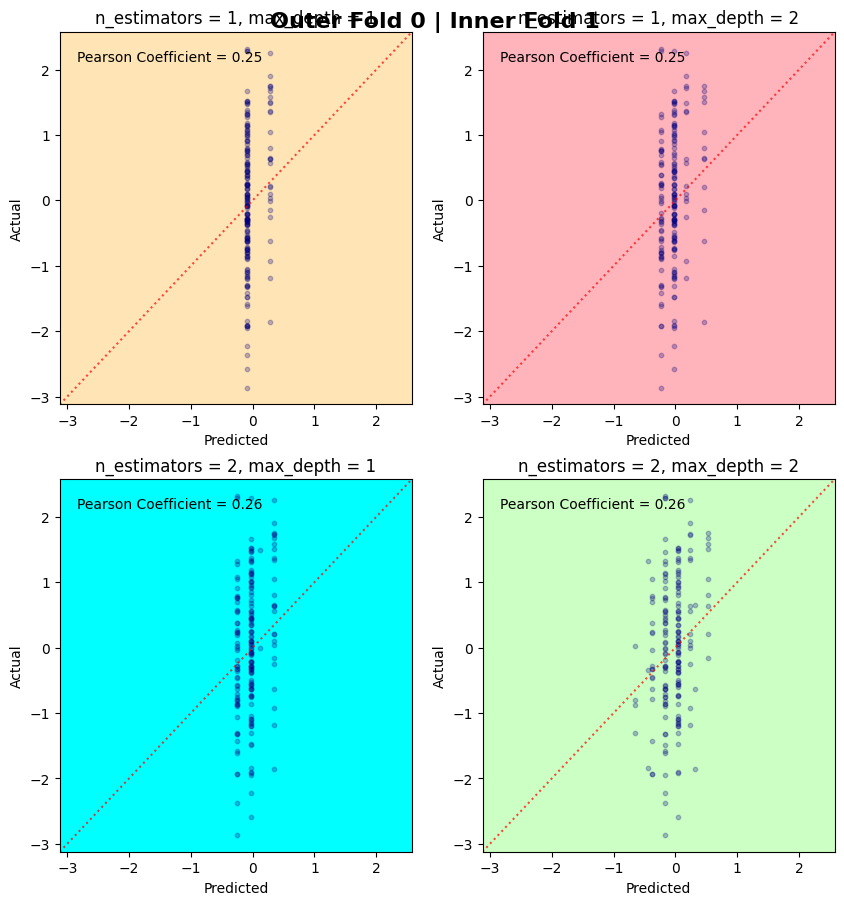

C:\Users\caoca\AppData\Local\Temp\ipykernel_26656\491992401.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)


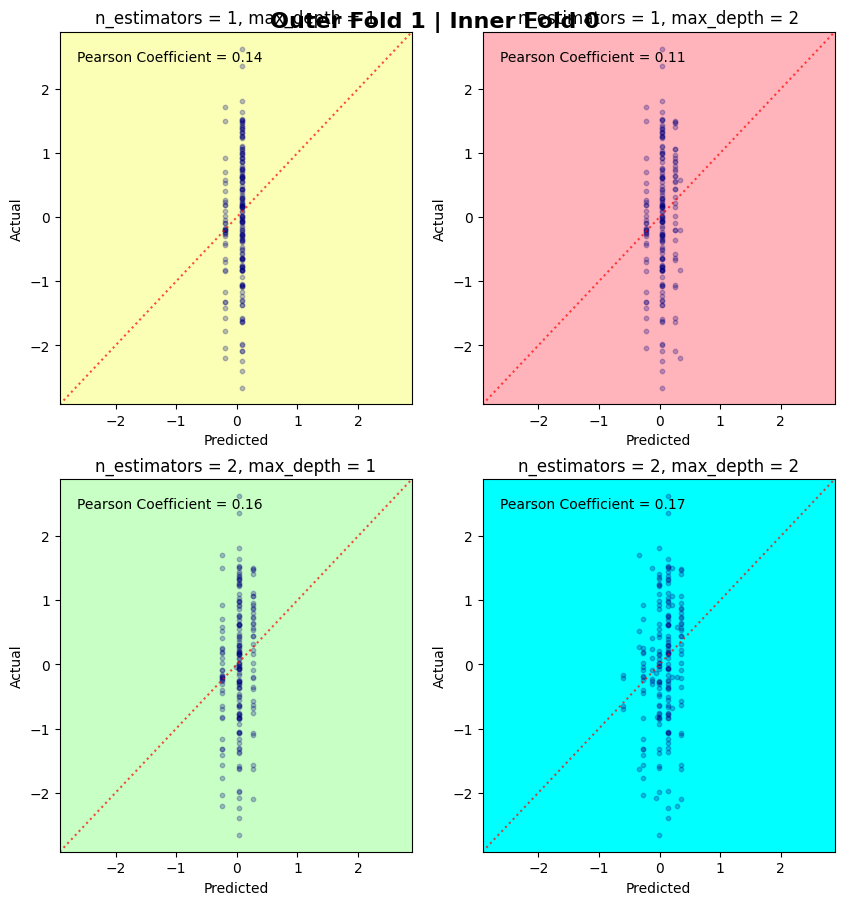

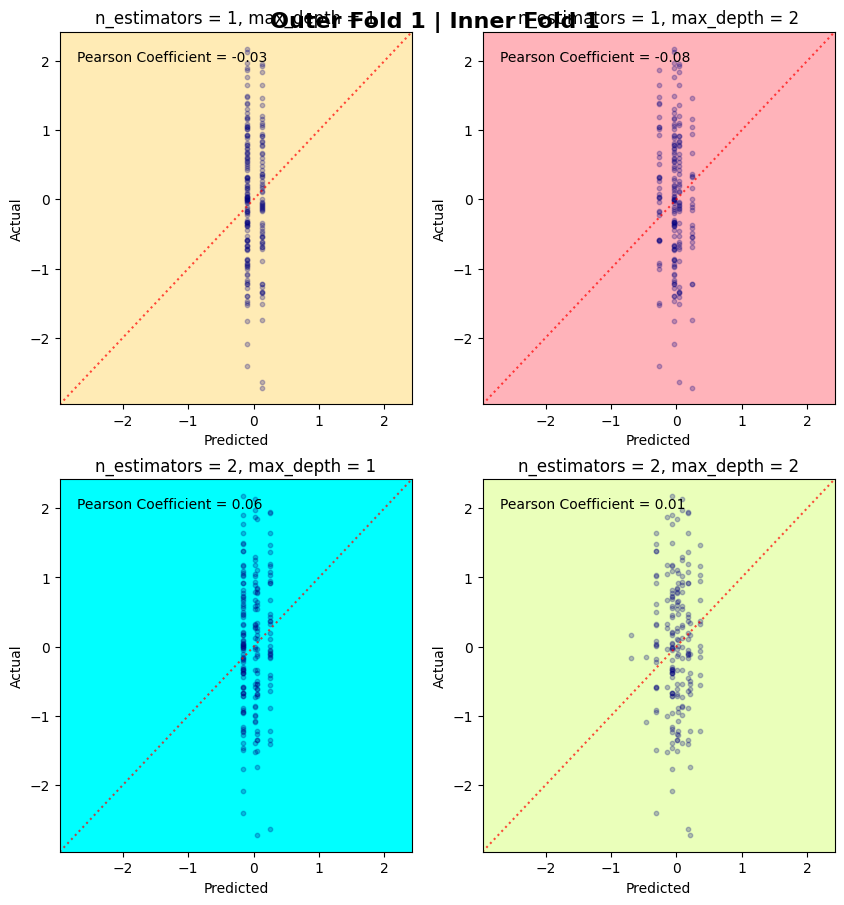

In [13]:
"""# proper values
x_params_XGB_R = mdo.AxisParams('n_estimators', [13, 25, 50, 100, 200])
y_params_XGB_R = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16])
# Perform grid search with XGBoost models
metrics_XGB_R = outer_CV_R(10, 5, X_sc, y_sc, x_params_XGB_R, y_params_XGB_R, bmo.train_XGB_regressor, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, objective="reg:squarederror", eval_metric="rmse")
"""
# dummy values
x_params_XGB_R = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_R = mdo.AxisParams('max_depth', [1, 2])
metrics_XGB_R = outer_CV_R(2, 2, X_sc, y_sc, x_params_XGB_R, y_params_XGB_R, bmo.train_XGB_regressor, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, objective="reg:squarederror", eval_metric="rmse", top_line_thresh=TOP_LINE_THRESH)


In [14]:
# display metrics
display(metrics_XGB_R)

Pearson  F1 Score  Sensitivity  Specificity     Kappa
0  0.255133   0.27673     0.285714     0.803922  0.087510
1  0.278483   0.34375     0.428571     0.732026  0.135564

In [15]:
# Print average of each metric
display(metrics_XGB_R.mean())

Pearson        0.266808
F1 Score       0.310240
Sensitivity    0.357143
Specificity    0.767974
Kappa          0.111537
dtype: float64

# Model B

In [16]:
def inner_CV_B(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, classification_col : int, plot_title: str = "", **kwargs):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # arrays to store best parameters for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # train model grid
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # use trained models to predict test set classification
        y_binary_preds_grid = bmo.grid_predict(X_test, model_grid)
        
        # also predict probabilities
        y_proba_preds_grid = bmo.grid_predict_proba(X_test, model_grid, classification_col)

        # create grid of actuals to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_proba_preds_grid.shape)

        # evaluate predictions by comparing to actuals, calculating f1 scores
        f1_grid = bmo.calculate_f1_scores(y_binary_preds_grid, y_test_grid)

        # find index of best f1 score in the 2d array of f1 scores
        best_row, best_col = np.unravel_index(np.argmax(f1_grid), f1_grid.shape)
        
        # store best parameters for this fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]

        # find classification threshold that yields lowest squared difference between sensitivity and specificity using this optimal model
        best_model_y_preds = y_proba_preds_grid[best_row, best_col]
        best_thresholds.iloc[i, 0] = bmo.find_optimal_threshold(y_test, best_model_y_preds)

        plot_shaded_roc_grids(y_proba_preds_grid, y_test_grid, axis1_params, axis2_params, f1_grid, plot_title, i)        

    # calculate average best parameters over all folds
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold

        

In [17]:
def outer_CV_B(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, classification_col : int, **kwargs) -> pd.DataFrame:
    
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # find average best values using inner fold CV
        best_param1, best_param2, best_threshold = inner_CV_B(n_inner_splits, X_train, y_train, axis1_params, axis2_params, train_model_callback, kfold_random_state, classification_col, plot_title=f"Outer Fold {i}", **kwargs)

        # train model with all training data of outer fold using average best parameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # use trained model to predict test set
        y_pred = pd.DataFrame(super_model.predict_proba(X_test)[:, classification_col], index=y_test.index, columns=y_test.columns)

        # calculate pearson coefficient
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))
        pearson = float(pearson)  # Convert numpy.float32 to Python float

        # classify predictions as top or not top
        y_pred_top = cdt.classify_top(y_pred, best_threshold)

        # calculate classification metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test)

        # combine pearson and classification metrics into one dataframe side by side, then add them to kfold_metrics
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)        
    
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics

In [18]:
# Replace range of labels with binary variable representing whether the gene line is top or not
y_sc_binary = cdt.classify_top(y_sc, TOP_LINE_THRESH) # .5, .6. .7
display(y_sc_binary)

GY
GID              
GID6569128  False
GID6688880   True
GID6688916  False
GID6688933  False
GID6688934  False
...           ...
GID6939917  False
GID6939919  False
GID6939938  False
GID6939941  False
GID6939945  False

[766 rows x 1 columns]

## SVM

c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower 

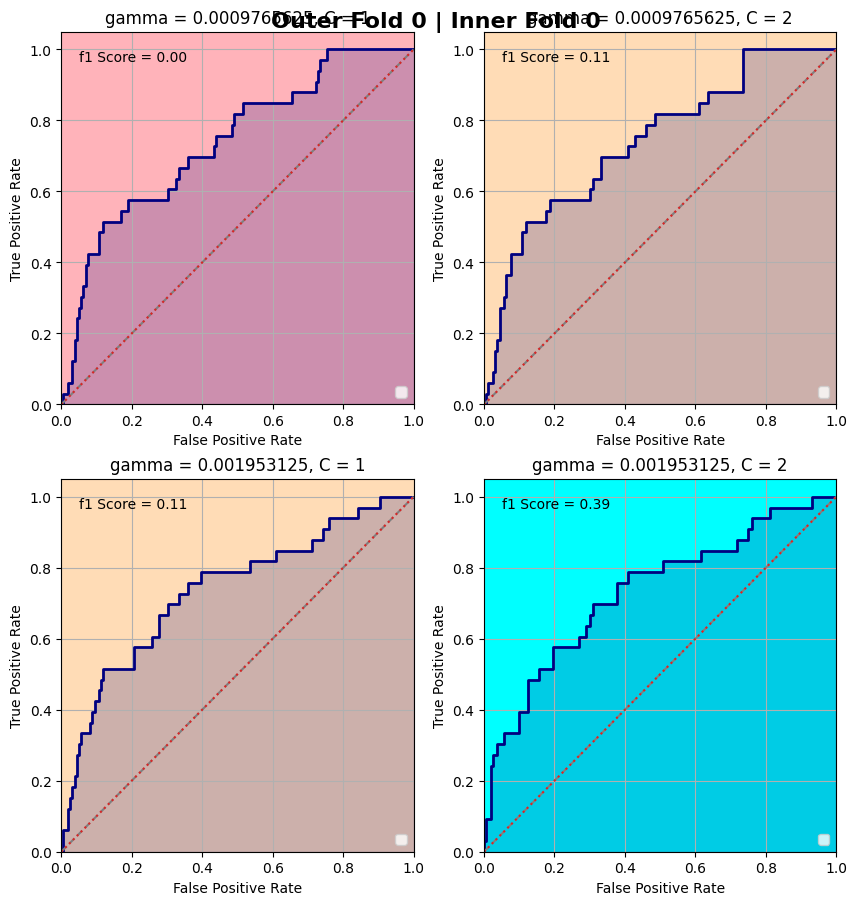

c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower 

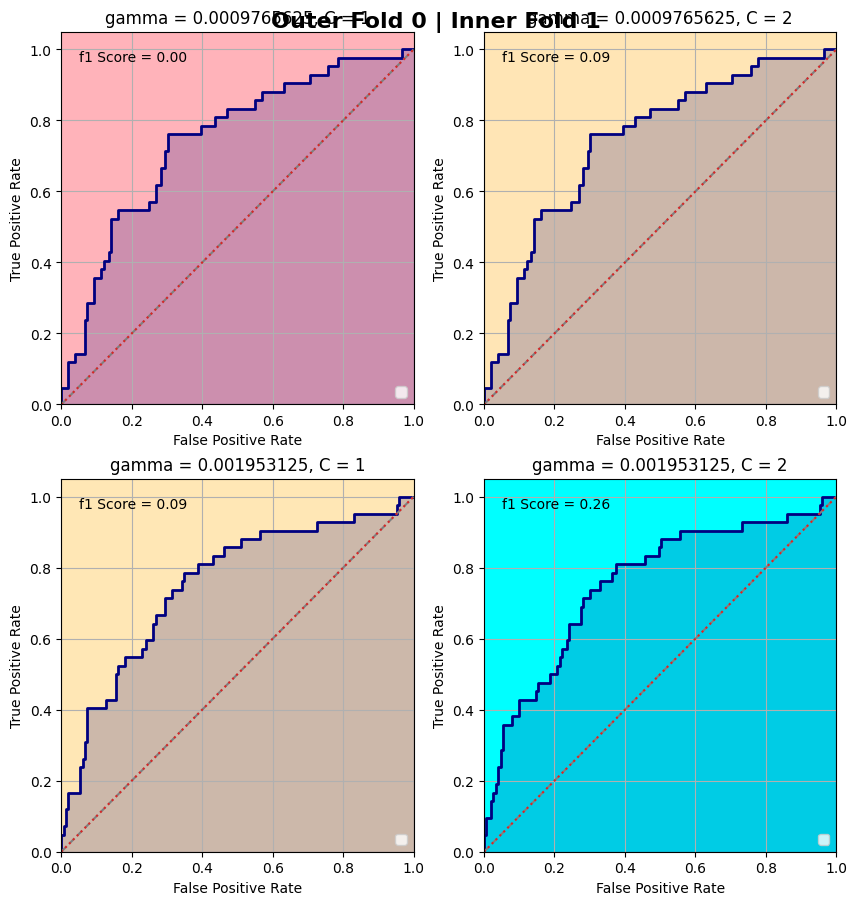

C:\Users\caoca\AppData\Local\Temp\ipykernel_26656\3902246721.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No a

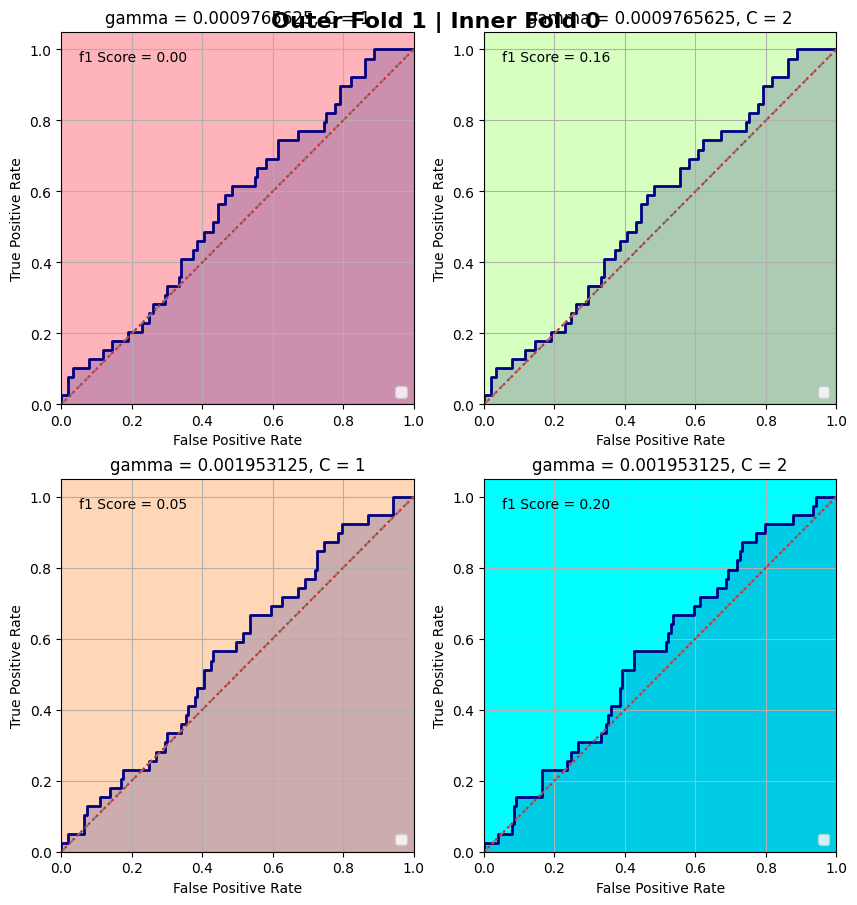

c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower 

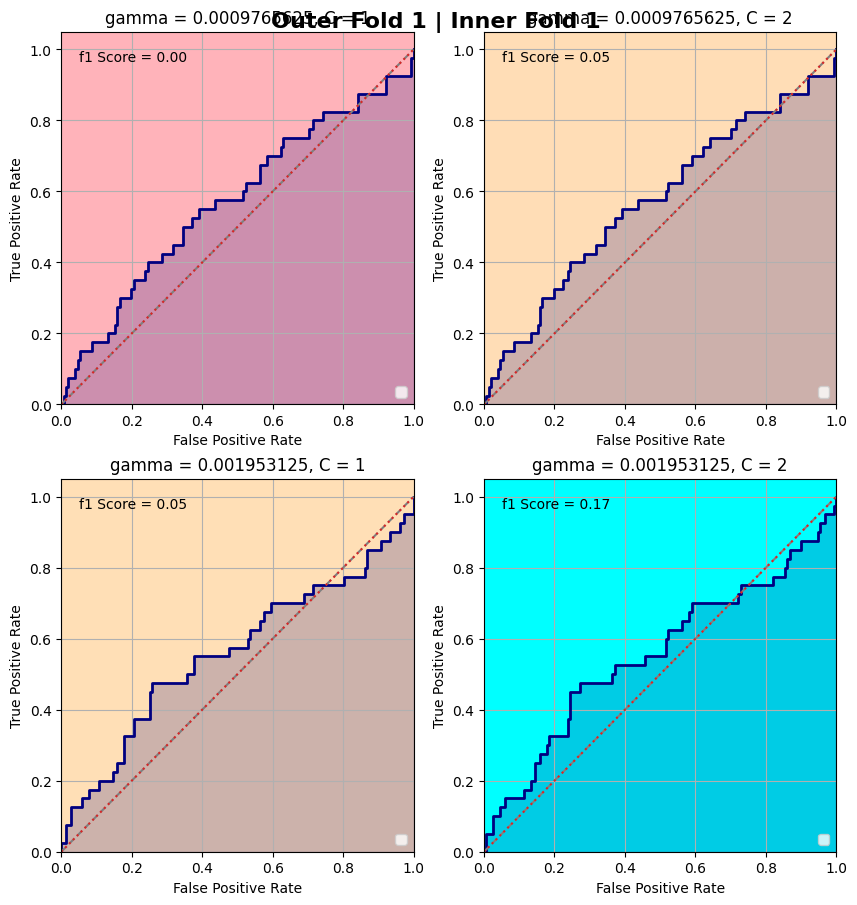

"\n# Real values\nx_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))\ny_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, -2, 6))\nmetrics_SVM_B = outer_CV_B(10, 5, X_sc, y_sc_binary, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, kfold_random_state=RANDOM_STATE, kernel='rbf', probability=True, classification_col=1)\n"

In [19]:
# Dummy values for tests
x_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -10, -9))
y_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
metrics_SVM_B = outer_CV_B(2, 2, X_sc, y_sc_binary, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, kfold_random_state=RANDOM_STATE, kernel='rbf', probability=True, classification_col=1)

"""
# Real values
x_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, -2, 6))
metrics_SVM_B = outer_CV_B(10, 5, X_sc, y_sc_binary, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, kfold_random_state=RANDOM_STATE, kernel='rbf', probability=True, classification_col=1)
"""


In [20]:
# display metrics
display(metrics_SVM_B)

Pearson  F1 Score  Sensitivity  Specificity     Kappa
0  0.252192  0.377551     0.936709     0.213816  0.071810
1  0.274098  0.357895     0.906667     0.230519  0.063513

In [21]:
# Print average of each metric
display(metrics_SVM_B.mean())

Pearson        0.263145
F1 Score       0.367723
Sensitivity    0.921688
Specificity    0.222168
Kappa          0.067662
dtype: float64

## XGBoost

c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower 

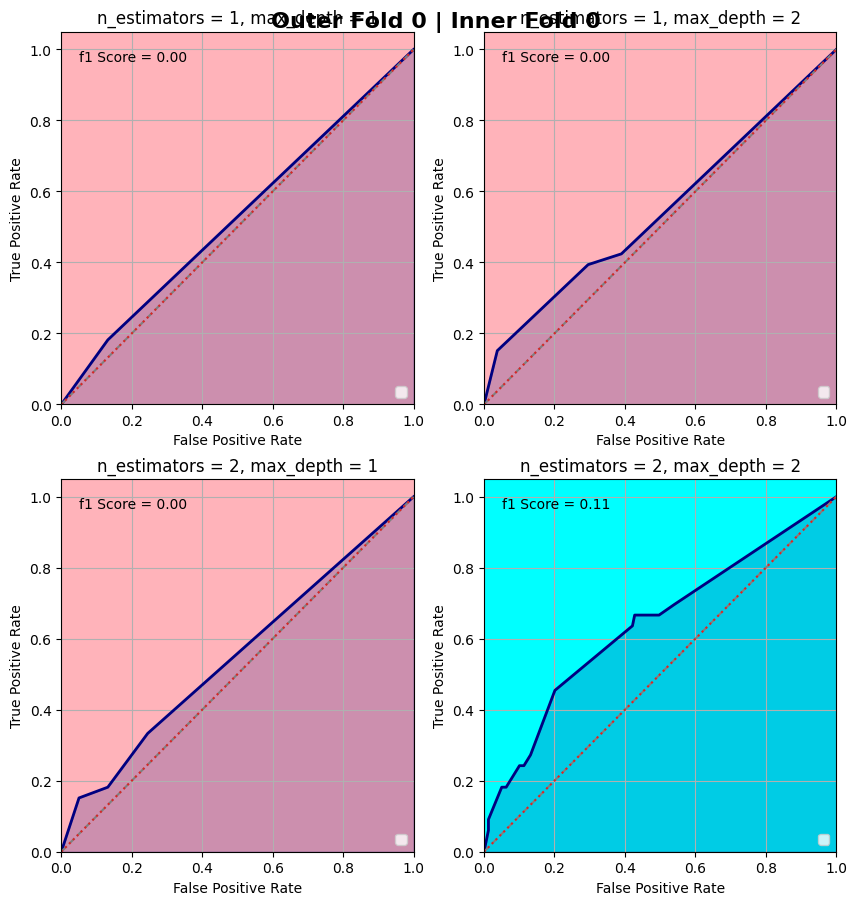

c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower 

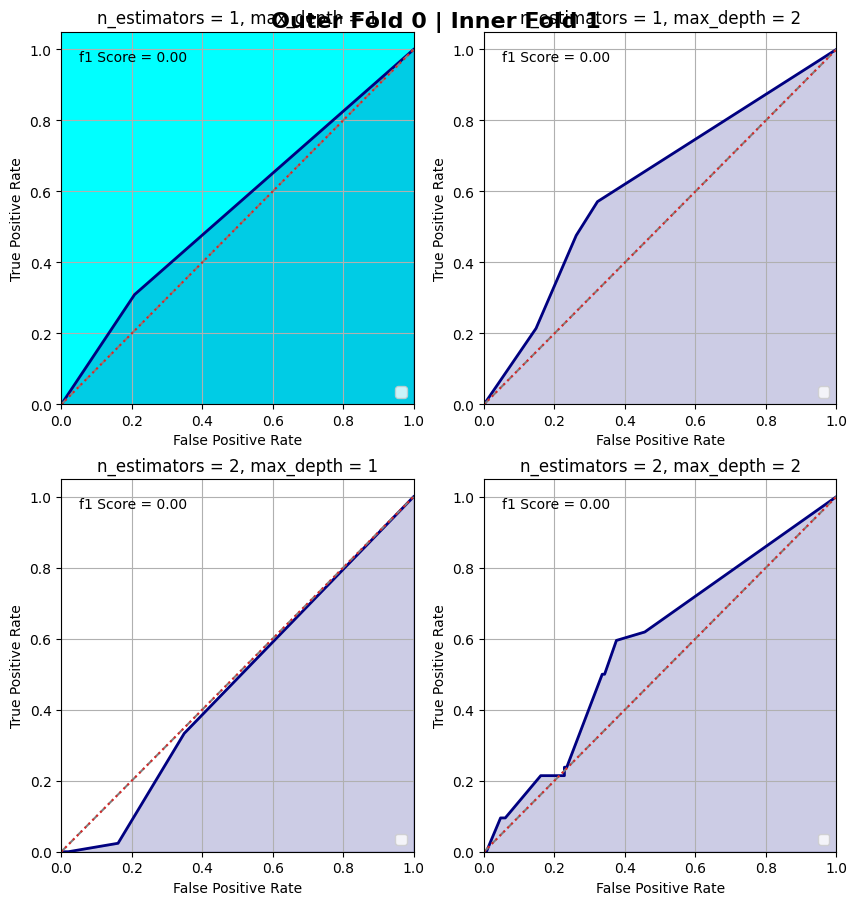

C:\Users\caoca\AppData\Local\Temp\ipykernel_26656\3902246721.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No a

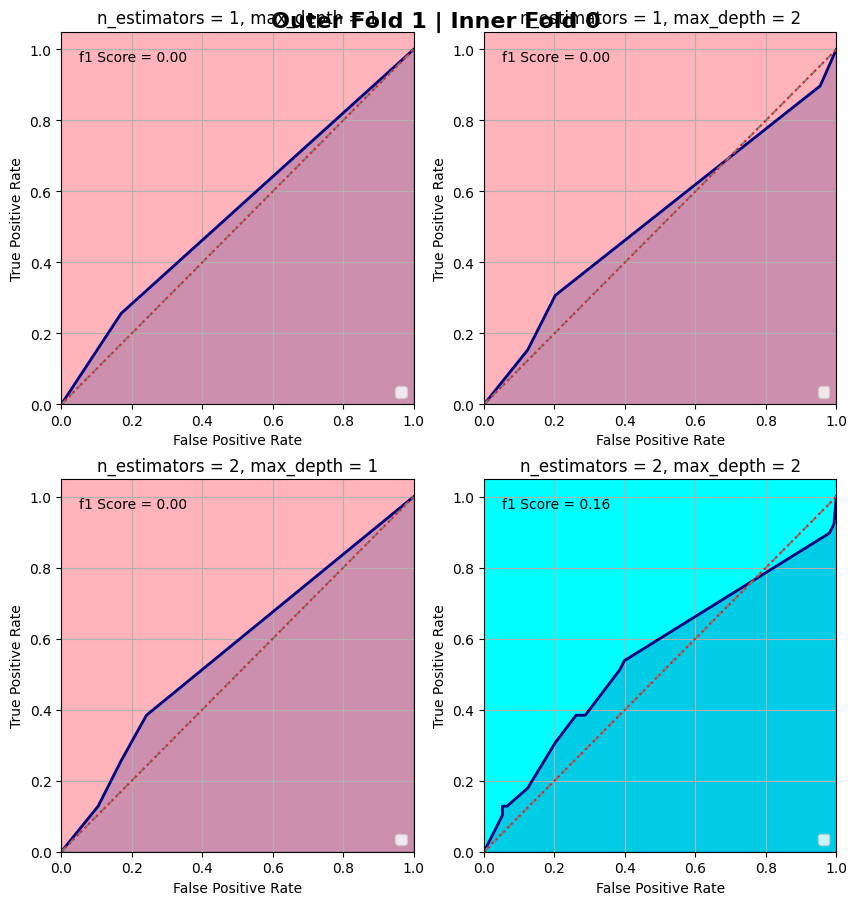

c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')
c:\Users\caoca\ml_research\custom_ml_plots.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower 

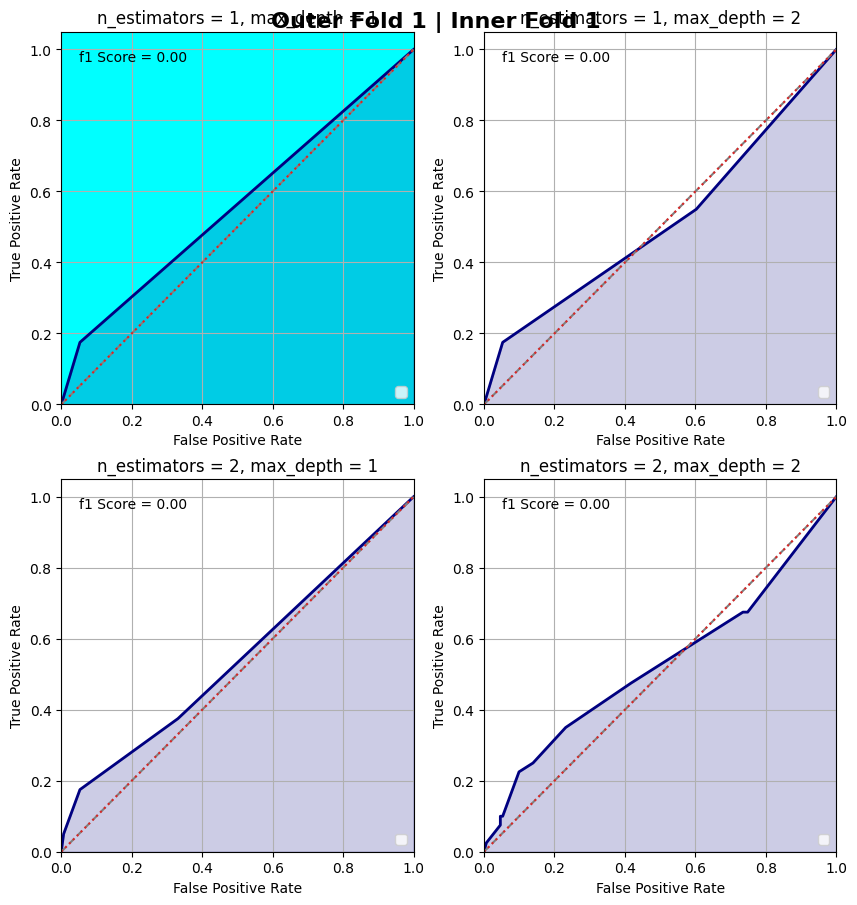

In [22]:
"""
x_params_XGB_B = mdo.AxisParams('n_estimators', [13, 25, 50, 100, 200])
y_params_XGB_B = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16])
metrics_XGB_B = outer_CV_B(10, 5, X_sc, y_sc_binary, x_params_XGB_B, y_params_XGB_B, bmo.train_XGB_classifier, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, classification_col=1, objective="binary:logistic", eval_metric="logloss")

"""

# dummy values for quick tests
x_params_XGB_B = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_B = mdo.AxisParams('max_depth', [1, 2])

metrics_XGB_B = outer_CV_B(2, 2, X_sc, y_sc_binary, x_params_XGB_B, y_params_XGB_B, bmo.train_XGB_classifier, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, classification_col=1, objective="binary:logistic", eval_metric="logloss")


In [23]:
# display metrics
display(metrics_XGB_B)

Pearson  F1 Score  Sensitivity  Specificity     Kappa
0  0.202623  0.341991     1.000000     0.000000  0.000000
1  0.073870  0.319635     0.933333     0.048701 -0.007325

In [24]:
# Print average of each metric
display(metrics_XGB_B.mean())

Pearson        0.138246
F1 Score       0.330813
Sensitivity    0.966667
Specificity    0.024351
Kappa         -0.003663
dtype: float64

# Model RO

In [25]:
def inner_CV_RO(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, top_line_threshold: float, plot_title: str = "", **kwargs):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # arrays to store best parameters for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # train model grid
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # use trained models to predict test set
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # create grid of actuals to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # evaluate predictions by comparing to actuals, calculating pearson coefficient
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        # find index of best pearson coefficient in the 2d array of pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # store best parameters for this fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]

        # find classification threshold that yields lowest squared difference between sensitivity and specificity using this optimal model
        best_model_y_preds = y_preds_grid[best_row, best_col]

        # classify actuals as top or not top
        y_test_binary = cdt.classify_top(y_test, top_line_threshold)

        # transform best model's predictions to between 0 and 1
        best_model_y_preds_transformed = (best_model_y_preds - best_model_y_preds.min()) / (best_model_y_preds.max() - best_model_y_preds.min())
        
        # find classification threshold that yields lowest squared difference between sensitivity and specificity using this optimal model
        best_thresholds.iloc[i, 0] = bmo.find_optimal_threshold(y_test_binary, best_model_y_preds_transformed)

        plot_shaded_scatter_grids(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, plot_title, i)        

    # calculate average best parameters over all folds
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold

        

In [26]:
def outer_CV_RO(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback : callable, kfold_random_state: int, top_line_threshold : float, **kwargs) -> pd.DataFrame:
    
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # find average best values using inner fold CV
        best_param1, best_param2, best_threshold = inner_CV_RO(n_inner_splits, X_train, y_train, axis1_params, axis2_params, train_model_callback, kfold_random_state, top_line_threshold=TOP_LINE_THRESH, plot_title=f"Outer Fold {i}", **kwargs)

        # train model with all training data of outer fold using average best parameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # use trained model to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)

        # calculate pearson coefficient
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # classify predictions and actuals as top or not top
        y_pred_top = cdt.classify_top(y_pred, best_threshold)
        y_test_top = cdt.classify_top(y_test, best_threshold)

        # calculate classification metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)

        # combine pearson and classification metrics into one dataframe side by side, then add them to kfold_metrics
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)        
    
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics

## SVM

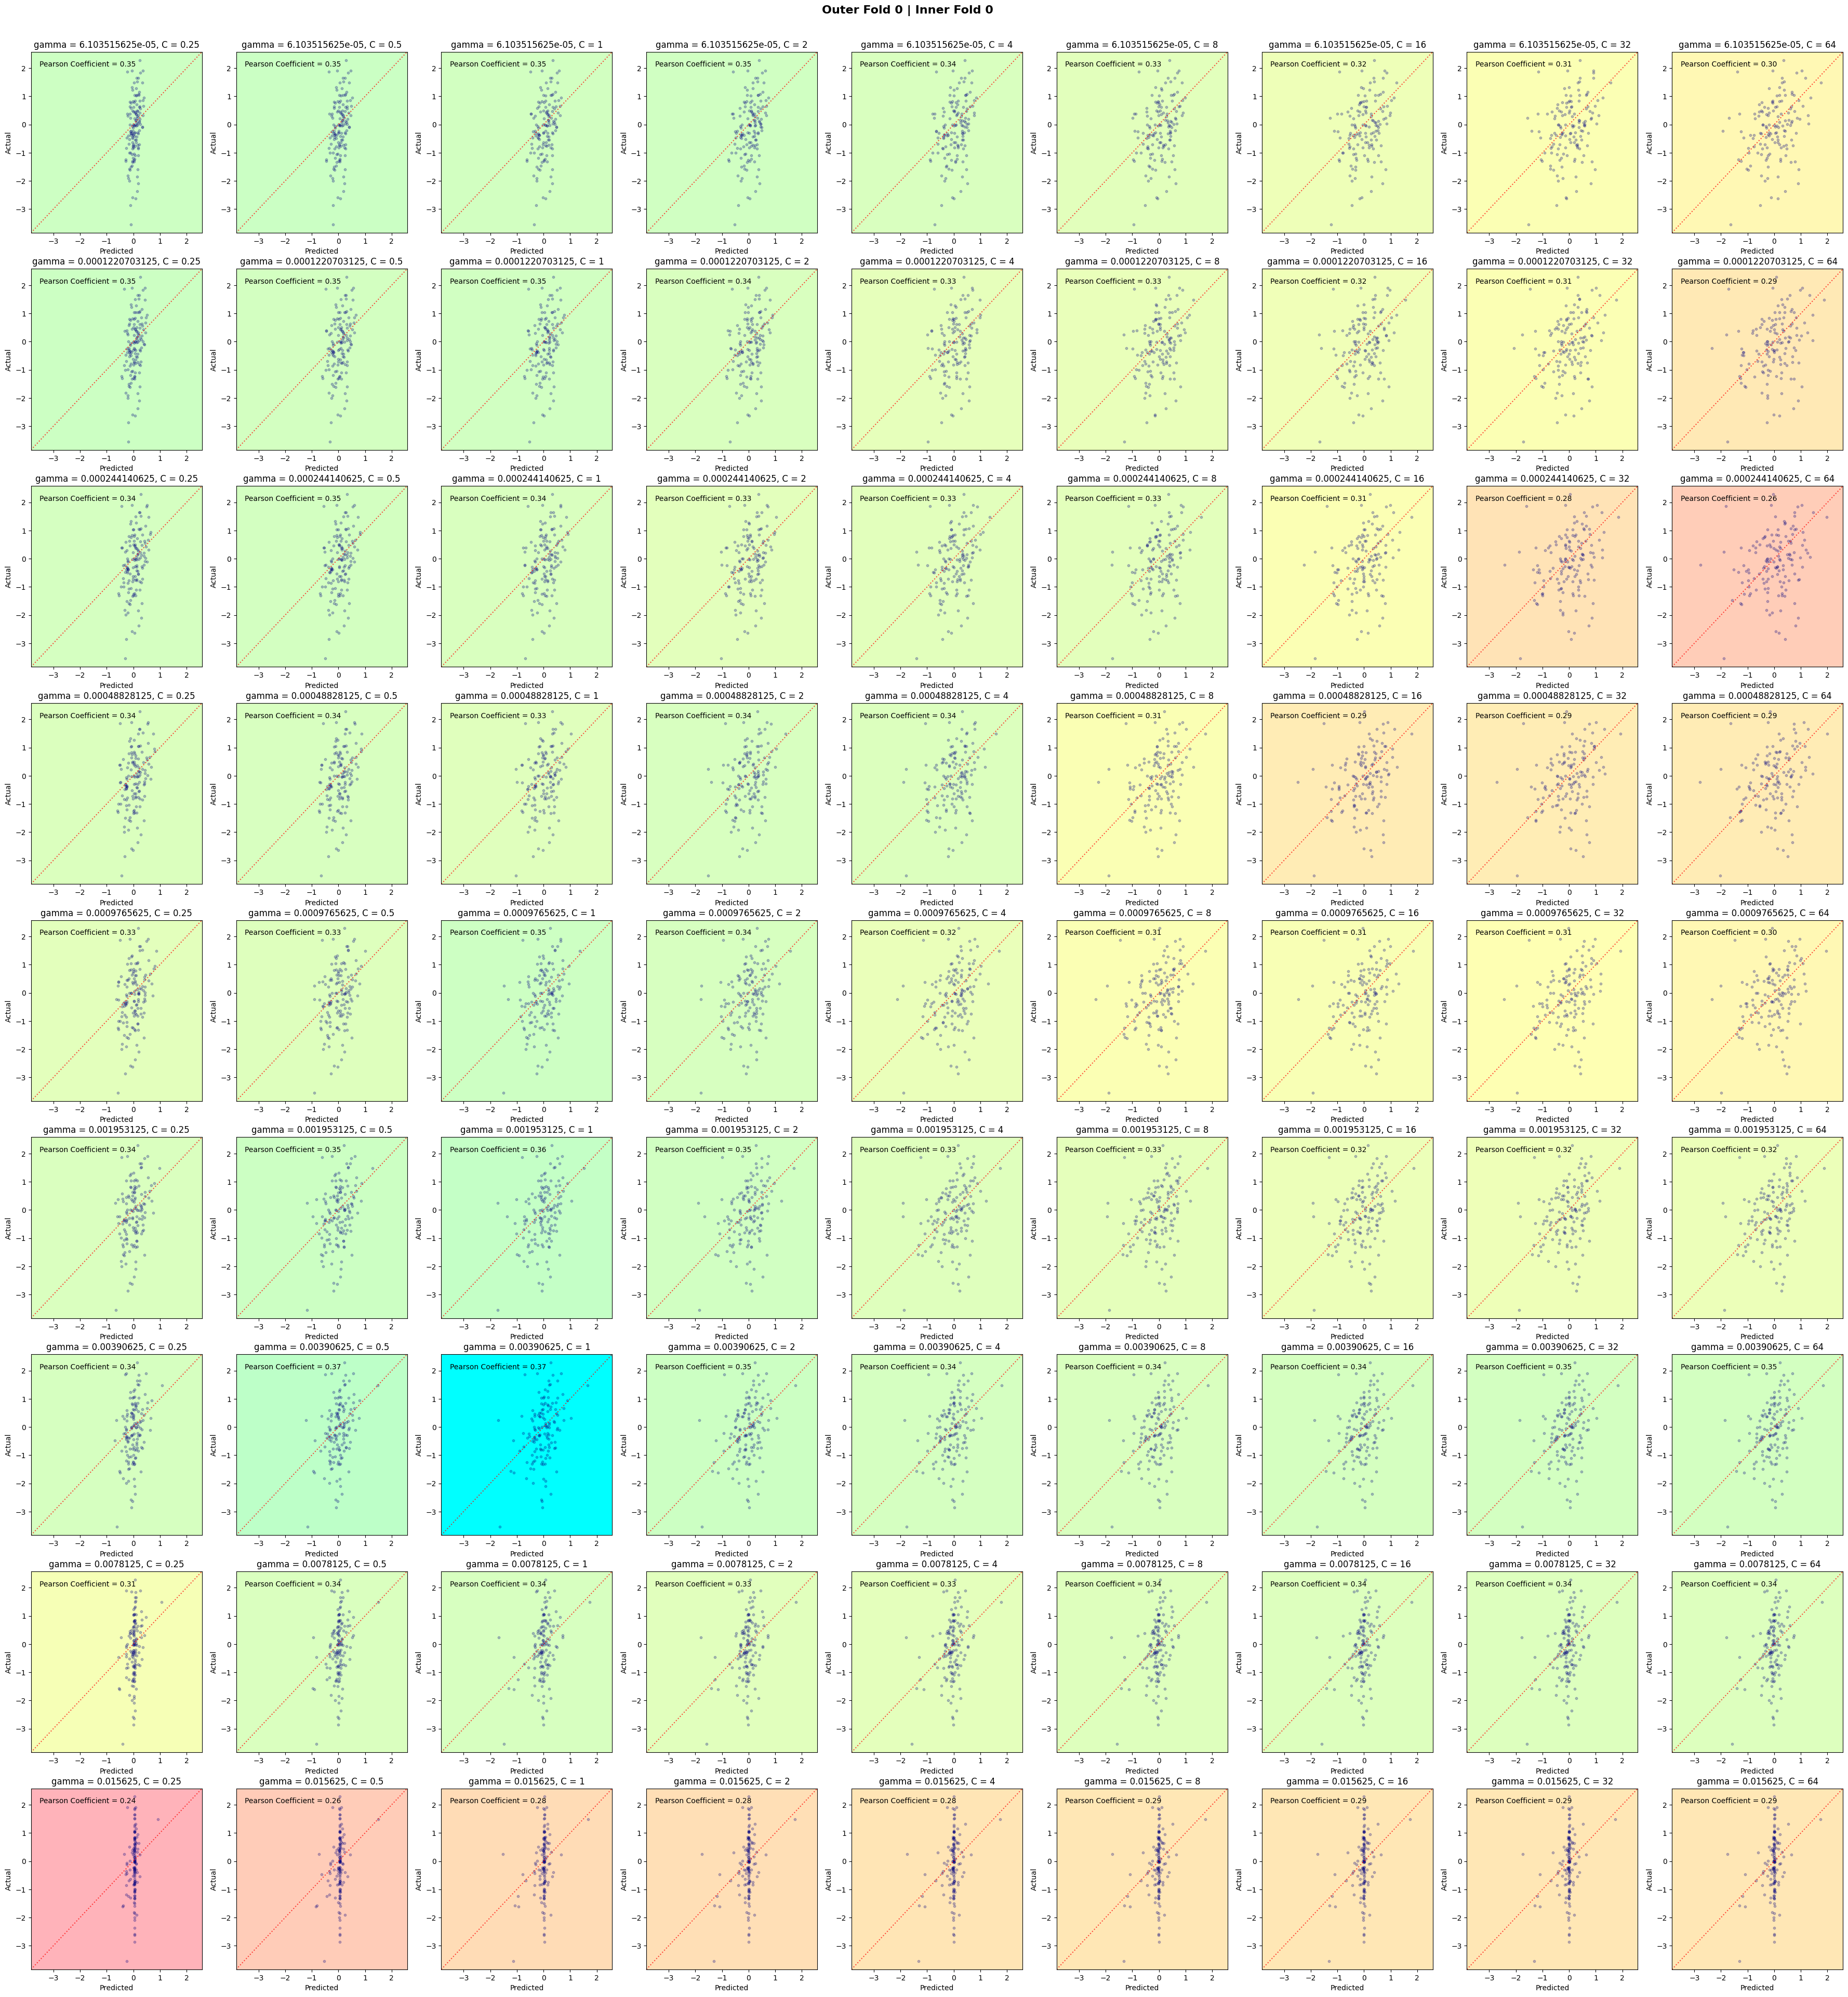

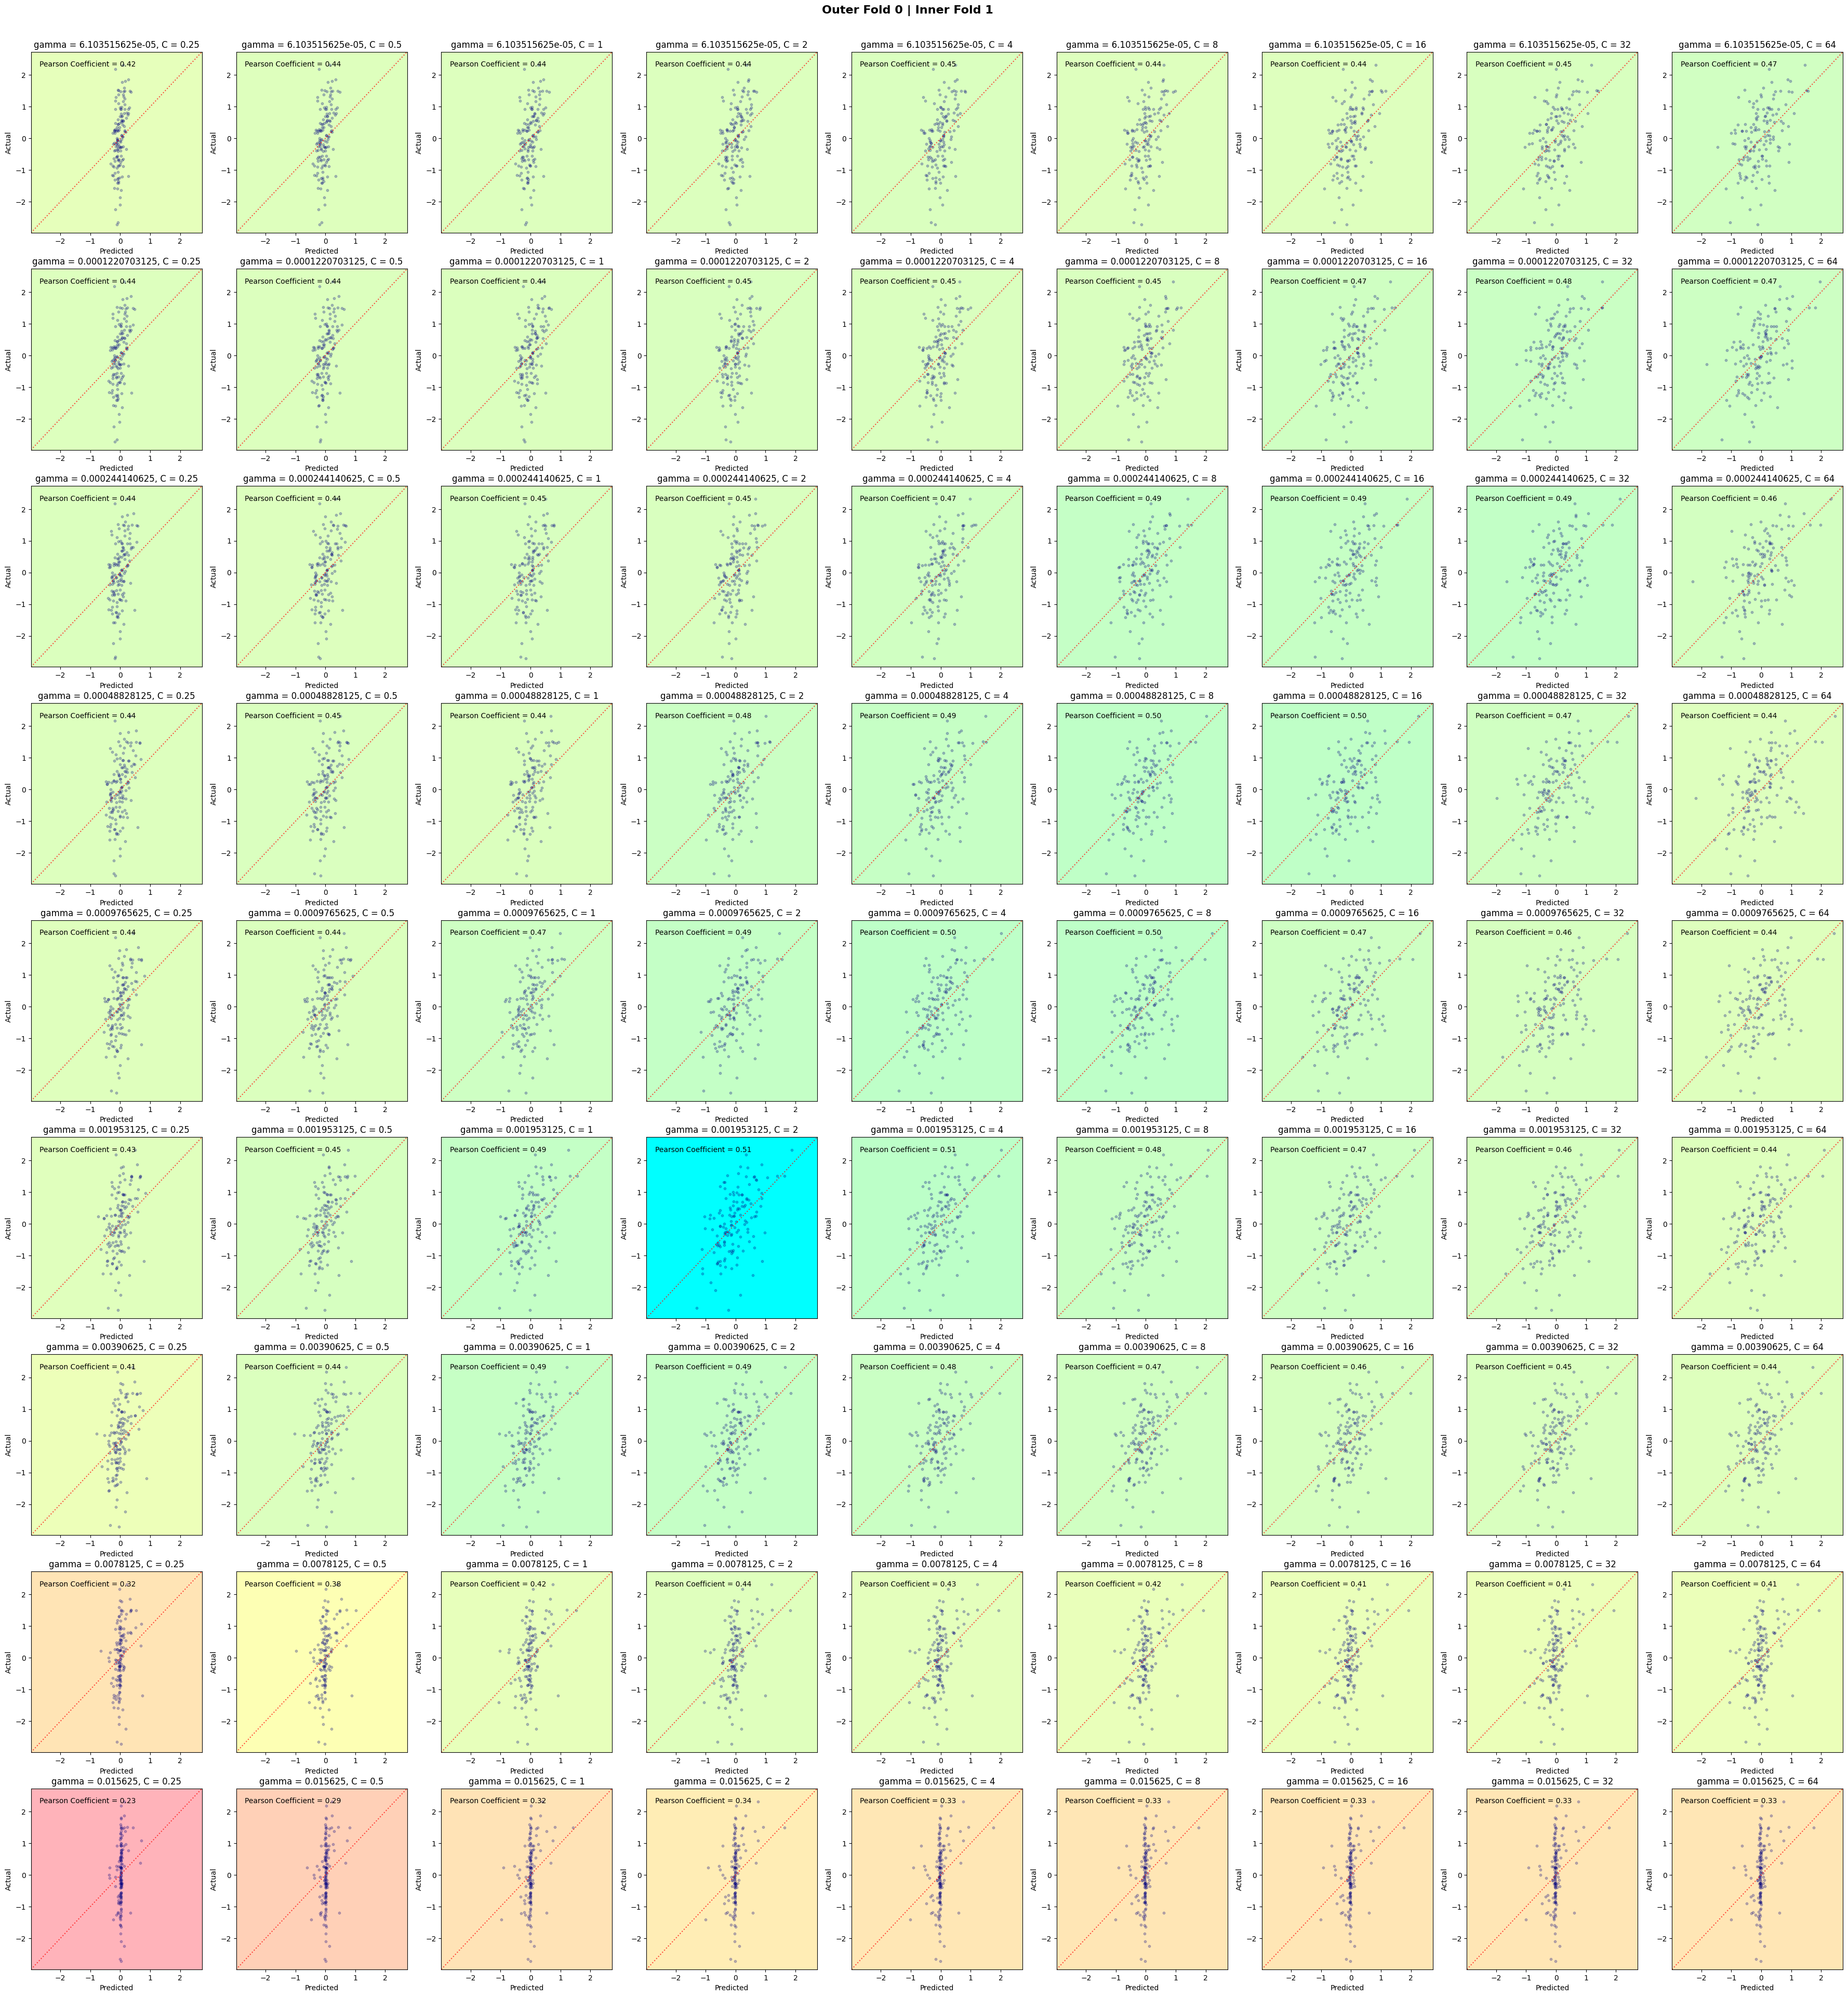

KeyboardInterrupt: 

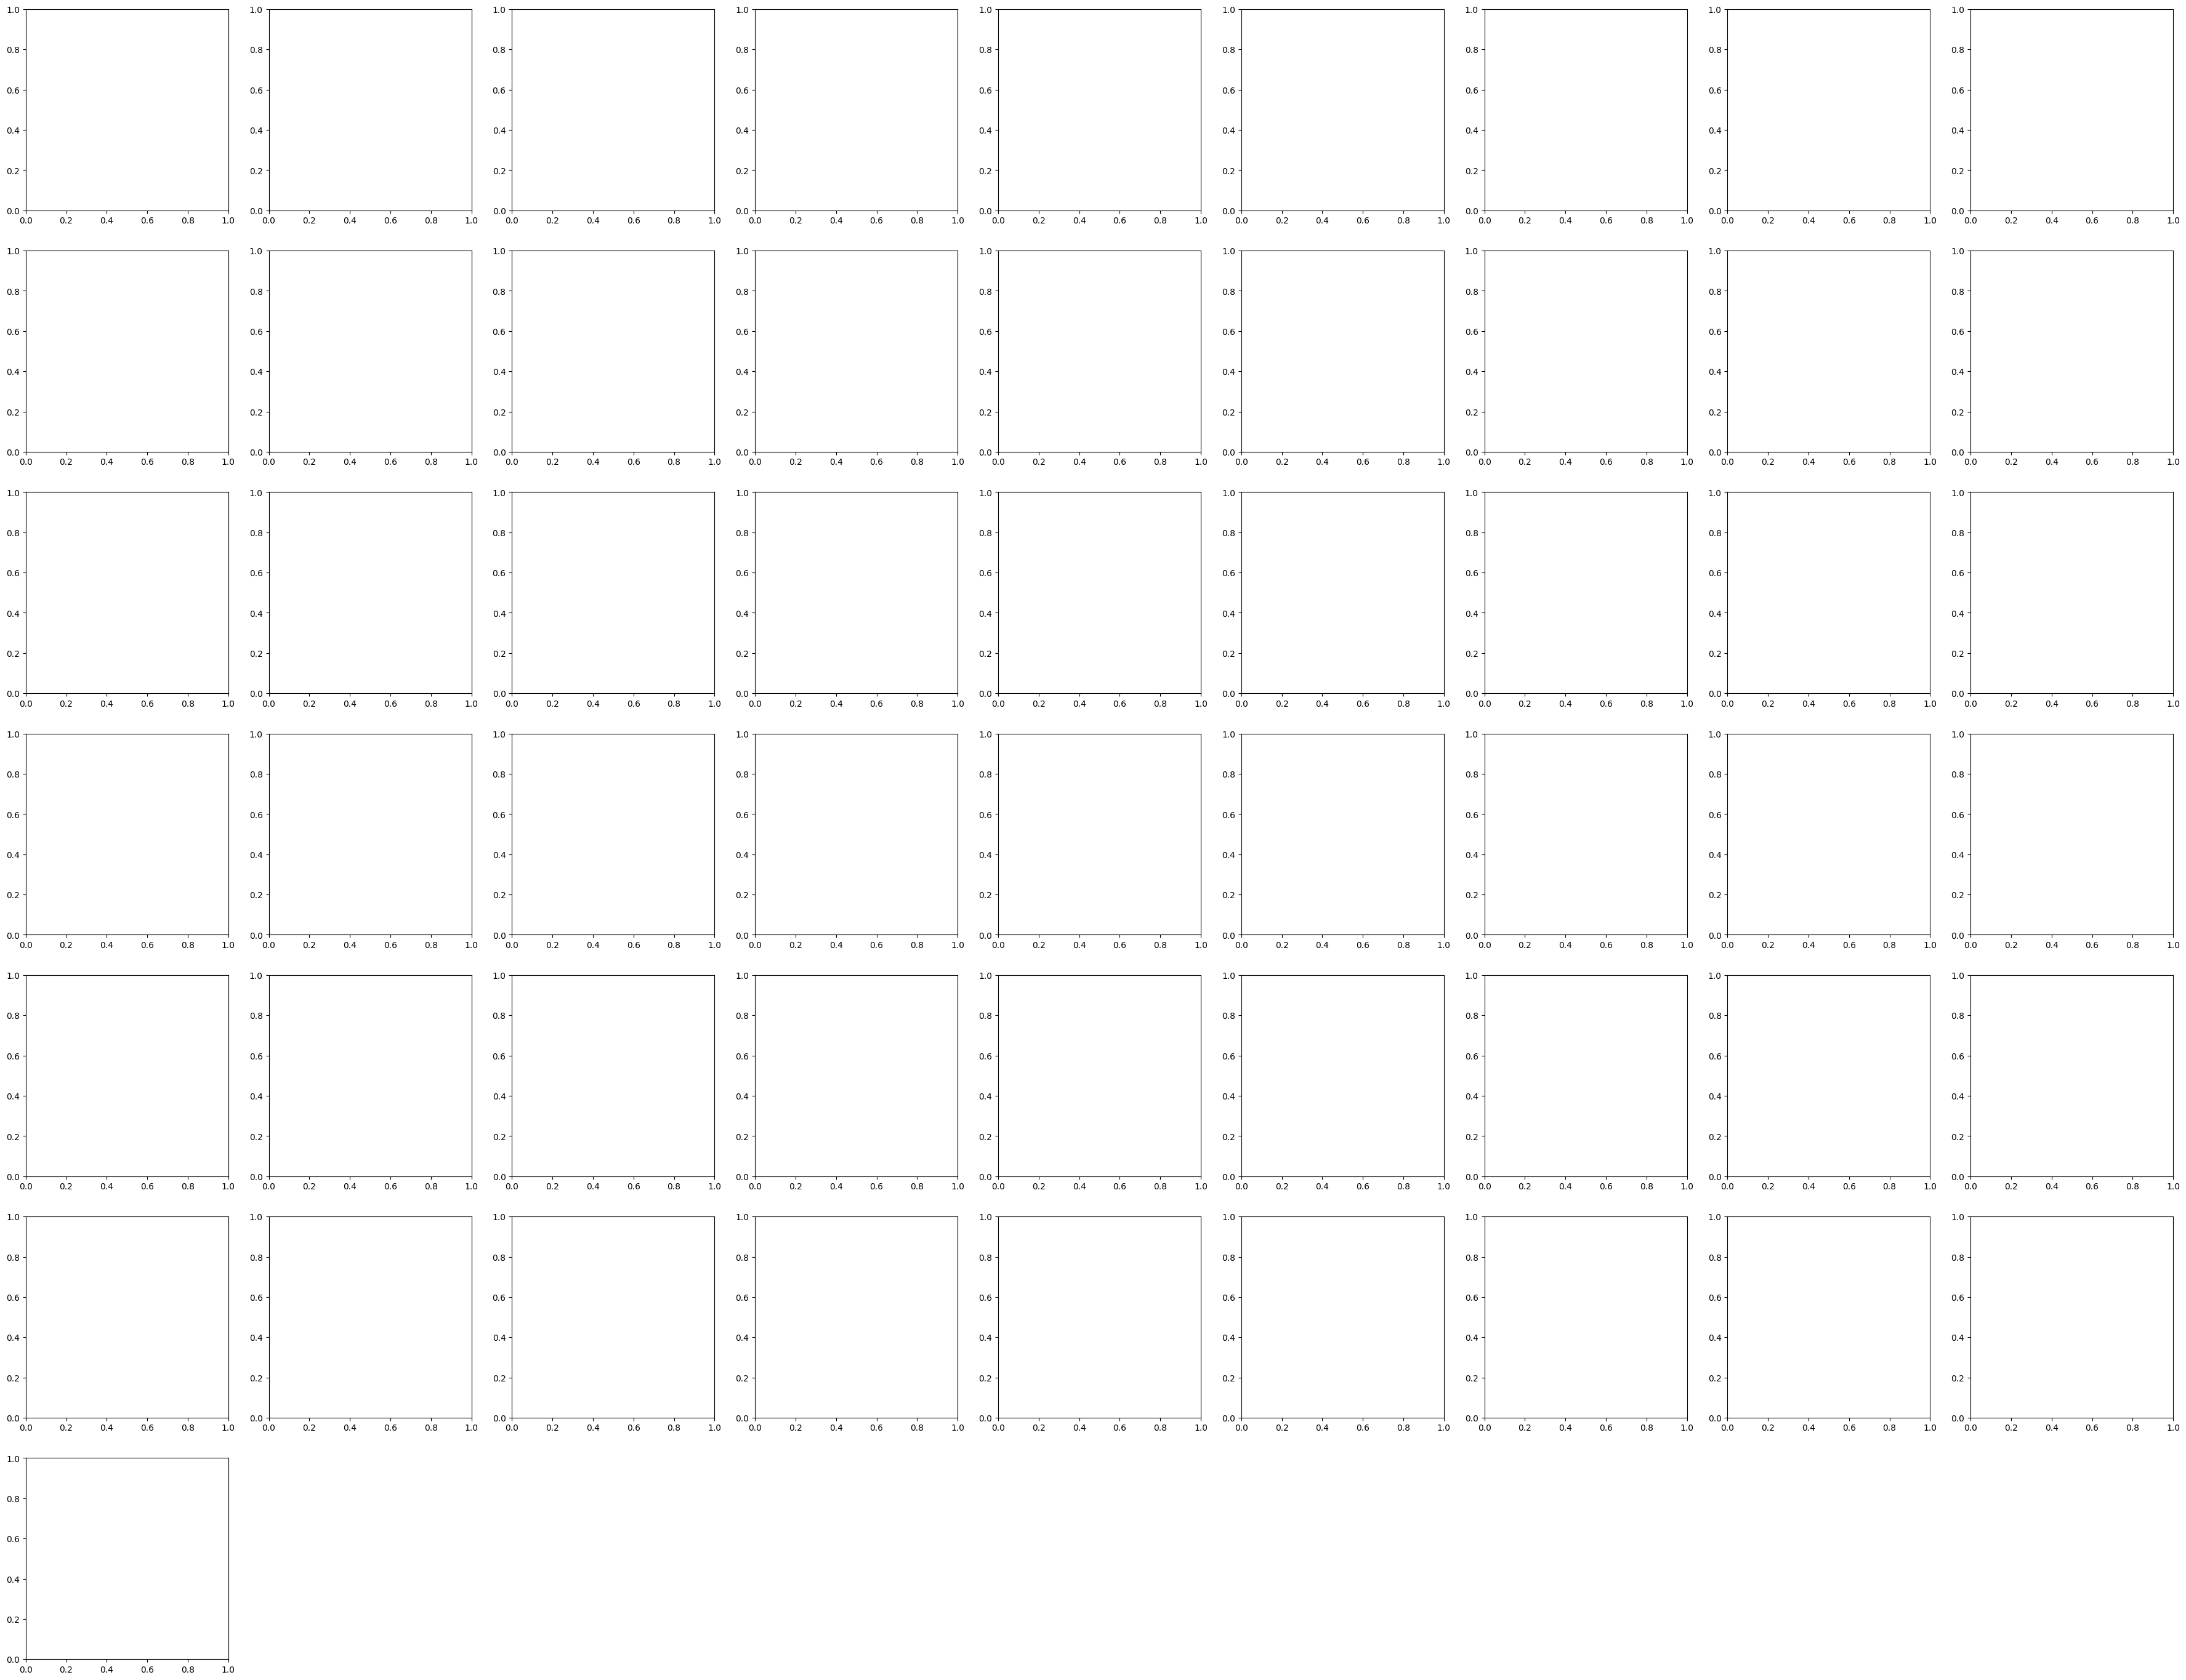

In [27]:
x_params_SVM_RO = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_RO = mdo.AxisParams('C', bmo.power_list(2, -2, 6))

metrics_SVM_RO = outer_CV_RO(10, 5, X_sc, y_sc, x_params_SVM_RO, y_params_SVM_RO, bmo.train_SVM_regressor, kfold_random_state=RANDOM_STATE, top_line_threshold=TOP_LINE_THRESH, kernel='rbf')

In [ ]:
# display metrics
display(metrics_SVM_RO)

In [ ]:
# Print average of each metric
display(metrics_SVM_RO.mean())

## XGBoost

In [ ]:
x_params_XGB_RO = mdo.AxisParams('n_estimators', [13, 25, 50, 100, 200])
y_params_XGB_RO = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16])
metrics_XGB_RO = outer_CV_RO(10, 5, X_sc, y_sc, x_params_XGB_RO, y_params_XGB_RO, bmo.train_XGB_regressor, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, objective="reg:squarederror", eval_metric="rmse")

In [ ]:
# display metrics
display(metrics_XGB_RO)

In [ ]:
# Print average of each metric
display(metrics_XGB_RO.mean())